In [1]:
"""An example notebook for a data_analysis notebook you may write.

Please use the recommended TNR font unless your venue requires otherwise.
"""

# Write down all of your code for data analysis in this file.
# Plot the data and save the figures/tables in the folders "plots" and "tables"
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import json
import pandas as pd
import numpy as np

# Use TNR for all figures
# to match paper templates
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]

# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]
plt.rcParams["figure.figsize"]


[6.4, 4.8]

In [29]:
# Reading in histories
multirun_dir="../multirun"
plots_dir="./plots"
tables_dir="./tables"

os.makedirs(plots_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)

eight_samples_iid_histories = {}
eight_samples_non_iid_histories = {}
large_and_small_histories = {}

strategies = ["FedAdagrad", "FedAdam", "FedAvg", "FedDC", "FedDC_5", "FedYogi"]

eight_samples_dir = os.path.join(multirun_dir, "8_samples")
for strategy in strategies:
    eight_samples_iid_histories[strategy] = {}
    eight_samples_non_iid_histories[strategy] = {}
    exp_dir = os.path.join(eight_samples_dir, strategy)
    iid_dir = os.path.join(exp_dir, "iid-True")
    non_iid_dir = os.path.join(exp_dir, "iid-False")
    seeds = [f.name for f in os.scandir(non_iid_dir) if f.is_dir()]
    for seed in seeds:
        seed_value = seed.split("-")[1]
        run_dir_iid = os.path.join(iid_dir, seed, "results/state/histories/history.json")
        run_dir_non_iid = os.path.join(non_iid_dir, seed, "results/state/histories/history.json")
        eight_samples_iid_histories[strategy][seed_value] = json.load(open(run_dir_iid, "r"))["metrics_centralized"]["test_accuracy"]
        eight_samples_non_iid_histories[strategy][seed_value] = json.load(open(run_dir_non_iid, "r"))["metrics_centralized"]["test_accuracy"]

eight_samples_iid_histories["Centralised"] = {}
eight_samples_non_iid_histories["Centralised"] = {}
eight_samples_centralised_dir = os.path.join(multirun_dir, "8_samples_centralised")
eight_samples_centralised_non_iid_dir = os.path.join(eight_samples_centralised_dir, "iid-False")
eight_samples_centralised_iid_dir = os.path.join(eight_samples_centralised_dir, "iid-True")
runs = [f.name for f in os.scandir(eight_samples_centralised_iid_dir) if f.is_dir()]
for run in runs:
    iid_run_dir = os.path.join(eight_samples_centralised_iid_dir,run)
    iid_run_dir = os.path.join(iid_run_dir, "results/state/histories/history.json")
    non_iid_run_dir = os.path.join(eight_samples_centralised_non_iid_dir,run)
    non_iid_run_dir = os.path.join(non_iid_run_dir, "results/state/histories/history.json")
    eight_samples_iid_histories["Centralised"][run] = json.load(open(iid_run_dir,"r"))["metrics_centralized"]["test_accuracy"]
    eight_samples_non_iid_histories["Centralised"][run] = json.load(open(non_iid_run_dir,"r"))["metrics_centralized"]["test_accuracy"]

strategies = ["FedAdagrad", "FedAdam", "FedAvg", "FedDC", "FedDC_5", "FedYogi", "FedDCW", "FedDCW_5"]
large_and_small_dir = os.path.join(multirun_dir, "large_and_small")
for strategy in strategies:
    large_and_small_histories[strategy] = {}
    exp_dir = os.path.join(large_and_small_dir, strategy)
    seeds = [f.name for f in os.scandir(exp_dir) if f.is_dir()]
    for seed in seeds:
        seed_value = seed.split("-")[1]
        run_dir = os.path.join(exp_dir, seed, "results/state/histories/history.json")
        large_and_small_histories[strategy][seed_value] = json.load(open(run_dir,"r"))["metrics_centralized"]["test_accuracy"]
        
large_and_small_centralised_dir = os.path.join(multirun_dir, "large_and_small_centralised")
large_and_small_histories["Centralised"] = {}

runs = [f.name for f in os.scandir(large_and_small_centralised_dir) if f.is_dir()]
for run in runs:
    run_dir = os.path.join(large_and_small_centralised_dir, run, "results/state/histories/history.json")
    large_and_small_histories["Centralised"][run] = json.load(open(run_dir))["metrics_centralized"]["test_accuracy"]


In [73]:
# Creating tables

def get_table_from_history(history, caption):
    data = []
    for strategy in history:
        final_accuracies = [history[strategy][seed][-1][1] for seed in history[strategy]]
        final_accuracies.sort()
        min_accuracy = final_accuracies[0]
        max_accuracy = final_accuracies[-1]
        median_accuracy = final_accuracies[len(final_accuracies) // 2]
        data.append({
            "Strategy": strategy,
            "Range": "{:.2f}".format(min_accuracy * 100) + " - " + "{:.2f}".format(max_accuracy * 100),
            "Median": "{:.2f}".format(median_accuracy * 100)
        })
    
    df = pd.DataFrame(data)
    df.set_index("Strategy", inplace=True)
    df.sort_values(by='Median', ascending=False, inplace=True)
    return df.to_latex(caption = caption)

eight_samples_iid_table_dir = os.path.join(tables_dir, "eight_samples_iid_table.tex")
eight_samples_non_iid_table_dir = os.path.join(tables_dir, "eight_samples_non_iid_table.tex")
large_and_small_table_dir = os.path.join(tables_dir, "large_and_small_table.tex")

# Storing tables
for (dir,history, caption) in [(eight_samples_iid_table_dir,eight_samples_iid_histories, 'Final accuracy on MNIST test set, trained on a small IID subset'),(eight_samples_non_iid_table_dir,eight_samples_non_iid_histories, "Final accuracy on MNIST test set, trained on a small non-IID subset"),(large_and_small_table_dir,large_and_small_histories, "Final accuracy on MNIST test set, trained on a subset with clients of varying quality")]:
    with open(dir, 'w') as file:
        file.write(get_table_from_history(history, caption))


In [64]:
def compare(baseline, accuracy_1, label_1, accuracy_2, label_2, ax, *args):
    ax.axhline(y=baseline, color='grey', linestyle='dashdot', linewidth = 0.7, label = 'Centralised final')
    random_run = list(accuracy_1.keys())[0]
    rounds = np.arange(len(accuracy_1[random_run]))
    mean_accuracy_1 = [0] * len(rounds)
    mean_accuracy_2 = [0] * len(rounds)
    for run in accuracy_1:
        for i in range(len(accuracy_1[run])):
            mean_accuracy_1[i] += accuracy_1[run][i][1]
    for run in accuracy_2:
        for i in range(len(accuracy_2[run])):
            mean_accuracy_2[i] += accuracy_2[run][i][1]
    mean_accuracy_1 = [x/len(accuracy_1) for x in mean_accuracy_1]
    mean_accuracy_2 = [x/len(accuracy_2) for x in mean_accuracy_2]
    rounds = np.arange(len(mean_accuracy_1))
    ax.plot(rounds, mean_accuracy_1, label=label_1, linestyle='dashed', lw=0.7)
    ax.plot(rounds, mean_accuracy_2, label=label_2, lw=0.7)
    for i in range(len(args)//2):
        accuracy = args[2*i]
        label = args[(2*i)+1]
        mean_accuracy = [0] * len(rounds)
        for run in accuracy:
            for i in range(len(accuracy[run])):
                mean_accuracy[i] += accuracy[run][i][1]
        mean_accuracy = [x/len(accuracy) for x in mean_accuracy]
        ax.plot(rounds, mean_accuracy, label=label, linestyle = 'dotted', lw=0.7)
    ax.set_ylim(0, 1)
    ax.legend()
    
def get_final_average_accuracy(accuracies):
    res=0
    for run in accuracies:
        res+=accuracies[run][-1][1]
    return res/(len(accuracies))

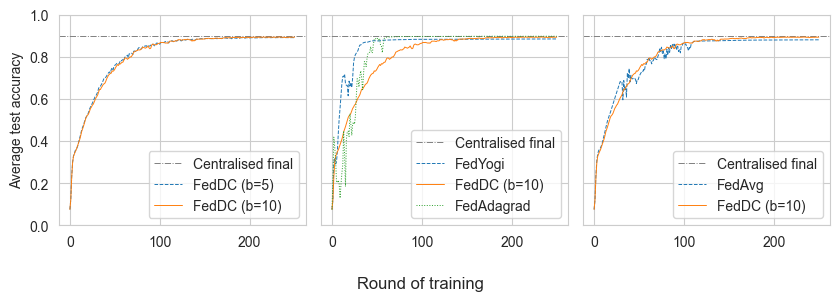

In [48]:
iid_centralised_accuracy = get_final_average_accuracy(eight_samples_iid_histories['Centralised'])

fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), sharex=True, sharey=True)
fig.supxlabel('Round of training')
ax[0].set(ylabel='Average test accuracy')
compare(iid_centralised_accuracy, eight_samples_iid_histories['FedAvg'],'FedAvg',eight_samples_iid_histories['FedDC'], 'FedDC (b=10)', ax[2])
compare(iid_centralised_accuracy, eight_samples_iid_histories['FedYogi'], 'FedYogi', eight_samples_iid_histories['FedDC'], 'FedDC (b=10)', ax[1], eight_samples_iid_histories['FedAdagrad'], 'FedAdagrad')
compare(iid_centralised_accuracy, eight_samples_iid_histories['FedDC_5'], 'FedDC (b=5)', eight_samples_iid_histories['FedDC'], 'FedDC (b=10)', ax[0])

iid_figure_dir = os.path.join(plots_dir, 'iid_figures.pgf')
fig.tight_layout()
plt.savefig(iid_figure_dir, format="pgf")
plt.show()

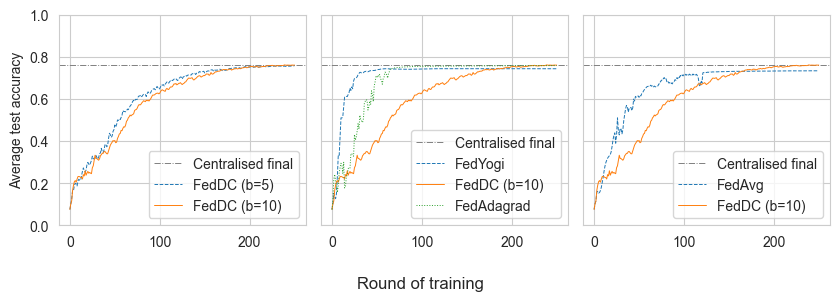

In [53]:
non_iid_centralised_accuracy = get_final_average_accuracy(eight_samples_non_iid_histories['Centralised'])

fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), sharex=True, sharey=True)
fig.supxlabel('Round of training')
ax[0].set(ylabel='Average test accuracy')
compare(non_iid_centralised_accuracy,eight_samples_non_iid_histories['FedAvg'],'FedAvg',eight_samples_non_iid_histories['FedDC'], 'FedDC (b=10)', ax[2])
compare(non_iid_centralised_accuracy,eight_samples_non_iid_histories['FedYogi'], 'FedYogi', eight_samples_non_iid_histories['FedDC'], 'FedDC (b=10)', ax[1], eight_samples_non_iid_histories['FedAdagrad'], 'FedAdagrad')
compare(non_iid_centralised_accuracy,eight_samples_non_iid_histories['FedDC_5'], 'FedDC (b=5)', eight_samples_non_iid_histories['FedDC'], 'FedDC (b=10)', ax[0])

iid_figure_dir = os.path.join(plots_dir, 'non_iid_figures.pgf')
fig.tight_layout()
plt.savefig(iid_figure_dir, format="pgf")
plt.show()

In [60]:
def truncate(accuracies):
    res={}
    for run in accuracies:
        res[run] = accuracies[run][0:30]
    return res

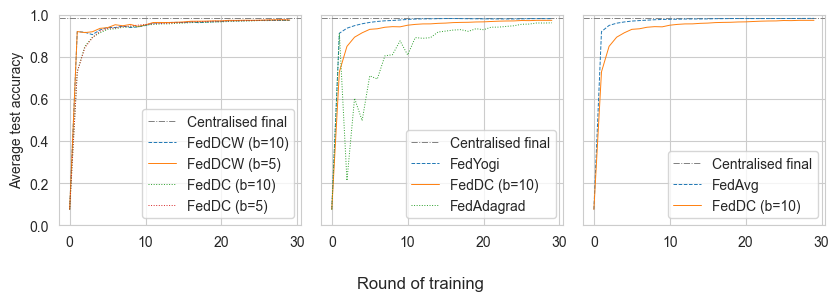

In [66]:
large_and_small_centralised_accuracy = get_final_average_accuracy(large_and_small_histories['Centralised'])

fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), sharex=True, sharey=True)
fig.supxlabel('Round of training')
ax[0].set(ylabel='Average test accuracy')
compare(large_and_small_centralised_accuracy,truncate(large_and_small_histories['FedAvg']),'FedAvg',truncate(large_and_small_histories['FedDC']), 'FedDC (b=10)', ax[2])
compare(large_and_small_centralised_accuracy,truncate(large_and_small_histories['FedYogi']), 'FedYogi', truncate(large_and_small_histories['FedDC']), 'FedDC (b=10)', ax[1], truncate(large_and_small_histories['FedAdagrad']), 'FedAdagrad')
compare(large_and_small_centralised_accuracy,truncate(large_and_small_histories['FedDCW']),'FedDCW (b=10)',truncate(large_and_small_histories['FedDCW_5']), 'FedDCW (b=5)', ax[0], truncate(large_and_small_histories['FedDC']), 'FedDC (b=10)', truncate(large_and_small_histories['FedDC_5']), 'FedDC (b=5)')

iid_figure_dir = os.path.join(plots_dir, 'large_and_small_figures.pgf')
fig.tight_layout()
plt.savefig(iid_figure_dir, format="pgf")
plt.show()